In [1]:
import numpy as np
from einops import rearrange

# from llava.probing.utils import *

from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import linalg

import os

from baukit import Trace, TraceDict

from llava.model import *
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.conversation import conv_templates, SeparatorStyle
from llava.mm_utils import tokenizer_image_token, get_model_name_from_path, KeywordsStoppingCriteria
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from utils import *

from transformers import AutoTokenizer
import torch

from PIL import Image
import json
import math
from functools import partial

[2023-11-14 17:48:27,083] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/opt/conda/envs/llava/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/envs/llava/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have 

In [29]:
llava

NameError: name 'llava' is not defined

In [3]:
 # HARDCODED FOR LLAVA
num_heads = 40
num_layers = 40

In [4]:
base_dir = '../probing/features_truthful/train'
val_ratio = 0.2
n_samples = 1000

head_truth = np.load(f"{base_dir}/truth/head_wise_{n_samples}_llm.npy")
labels_truth = np.load(f"{base_dir}/truth/labels_{n_samples}.npy")
head_truth = rearrange(head_truth, 'b l (h d) -> b l h d', h = num_heads)

head_non_truth = np.load(f"{base_dir}/non_truth/head_wise_{n_samples}_llm.npy")
labels_non_truth = np.load(f"{base_dir}/non_truth/labels_{n_samples}.npy")
head_non_truth = rearrange(head_non_truth, 'b l (h d) -> b l h d', h = num_heads)

In [5]:
!pwd

/home/ubuntu/llava_probing/llava/editing


## Lets check the probe accuracies

In [6]:
X_all = np.vstack((head_truth, head_non_truth))
y_all = np.hstack((labels_truth, labels_non_truth))

head_perf_dict = {f'l{l}_h{h}': [] for l in range(num_layers) for h in range(num_heads)}
probes_dict = {f'l{l}_h{h}': None for l in range(num_layers) for h in range(num_heads)}
for l in tqdm(range(num_layers)):
    for h in range(num_heads):
        X_probe = X_all[:, l, h, :]
        y_probe = y_all[:]
        probe, val_acc = train_single_prob(X_probe, y_probe, val_size=val_ratio)
        head_perf_dict[f'l{l}_h{h}'] = val_acc
        probes_dict[f'l{l}_h{h}'] = probe

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:24<00:00,  1.65it/s]


In [7]:
head_perf_dict_mean = {k: np.mean(v) for k,v in head_perf_dict.items()}
head_perf_dict_std = {k: np.std(v) for k,v in head_perf_dict.items()}
l_h_means = np.array(list(head_perf_dict_mean.values())).reshape(num_heads, num_layers) # row = heads | colums = layers

/tmp/ipykernel_1072146/3750881555.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plt.cm.get_cmap('viridis')


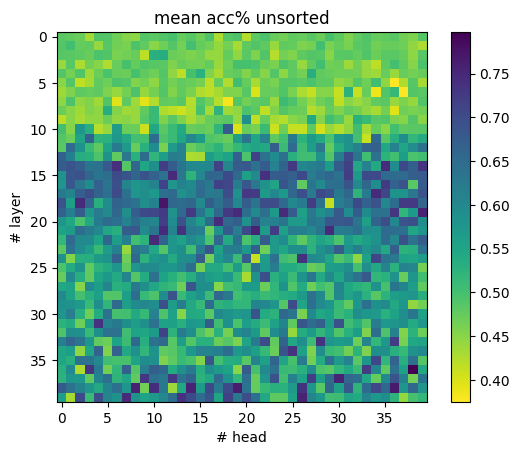

In [8]:
orig_map=plt.cm.get_cmap('viridis') 
reversed_map = orig_map.reversed() 
# l_h_means_sorted = -np.sort(-l_h_means, axis=1) #sort by head, layers unchanged
plt.imshow(l_h_means, cmap = reversed_map)
plt.xlabel('# head')
plt.ylabel('# layer')
plt.colorbar()
plt.title('mean acc% unsorted')
plt.show()

## Lets see the head acc distribution

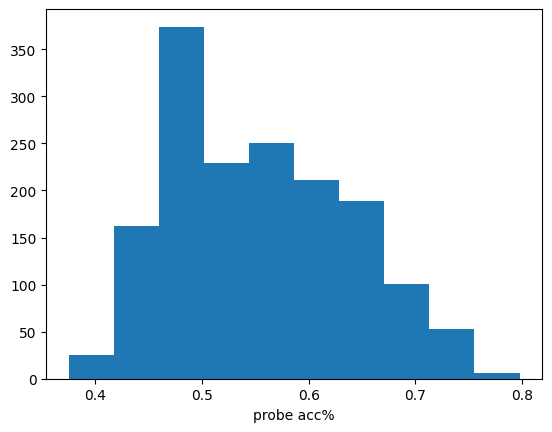

In [9]:
l_h_means_flattened = l_h_means.flatten()
counts, bins = np.histogram(l_h_means_flattened)
plt.hist(bins[:-1], bins, weights=counts)
plt.xlabel('probe acc%')
plt.show()

## Ok lets get on to the actual editing

In [10]:
acc_threshold = 0.65
num_to_intervene = len(np.argwhere(l_h_means_flattened > acc_threshold))
alpha=15
top_heads = []

def flattened_idx_to_layer_head(flattened_idx, num_heads):
    return flattened_idx // num_heads, flattened_idx % num_heads

def layer_head_to_flattened_idx(layer, head, num_heads):
    return layer * num_heads + head
    
def get_top_heads(l_h_means, num_to_intervene):
    top_accs = np.argsort(l_h_means.reshape(num_heads*num_layers))[::-1][:num_to_intervene]
    top_heads = [flattened_idx_to_layer_head(idx, num_heads) for idx in top_accs]
    return top_heads

In [11]:
print(f"Number of heads with probe acc > {acc_threshold} = {len(np.argwhere(l_h_means_flattened > acc_threshold))}")

Number of heads with probe acc > 0.65 = 232


In [12]:
def get_com_directions(num_layers, num_heads, head_activations, labels): 
    com_directions = []
    for layer in tqdm(range(num_layers)): 
        for head in range(num_heads):
            probe_activations = head_activations[:,layer,head,:]
            true_mass_mean = np.mean(probe_activations[labels == 1], axis=0)
            false_mass_mean = np.mean(probe_activations[labels == 0], axis=0)
            com_directions.append(true_mass_mean - false_mass_mean)
    com_directions = np.array(com_directions)
    return com_directions

In [13]:
def get_interventions_dict(top_heads, probes_dict, tuning_activations, num_to_intervene, use_center_of_mass=False, com_directions=None):
    interventions = {}
    probes = np.array(list(probes_dict.values()))
    for layer, head in top_heads: 
        interventions[f"model.layers.{layer}.self_attn.o_proj"] = []
    for layer, head in top_heads:
        if use_center_of_mass:
            direction = com_directions[layer_head_to_flattened_idx(layer, head, num_heads)]
        else:
            direction = probes[layer_head_to_flattened_idx(layer, head, num_heads)].coef_
        direction = direction / np.linalg.norm(direction)
        activations = tuning_activations[:,layer,head,:] # batch x 128
        proj_vals = activations @ direction.T
        proj_val_std = np.std(proj_vals)
        interventions[f"model.layers.{layer}.self_attn.o_proj"].append((head, direction.squeeze(), proj_val_std))
    for layer, head in top_heads: 
        interventions[f"model.layers.{layer}.self_attn.o_proj"] = sorted(interventions[f"model.layers.{layer}.self_attn.o_proj"], key = lambda x: x[0])
    return interventions

In [14]:
# same default alpha as ITI
def lt_modulated_vector_add(head_output, layer_name, start_edit_location='lt'): 
    head_output = rearrange(head_output, 'b s (h d) -> b s h d', h=num_heads)
    for head, direction, proj_val_std in interventions[layer_name]:
        direction_to_add = torch.tensor(direction).to(device)
        if start_edit_location == 'lt': 
            head_output[:, -1, head, :] = alpha * proj_val_std * direction_to_add
        else: 
            head_output[:, start_edit_location:, head, :] += alpha * proj_val_std * direction_to_add
    head_output = rearrange(head_output, 'b s h d -> b s (h d)')
    return head_output

In [30]:
def get_answer_with_intervention(model, tokenizer, prompt, images, stopping_criteria, interventions={}, intervention_fn=None):
    input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt')
    input_ids = input_ids.unsqueeze(0).cuda()
    # --- intervention code --- #
    def id(head_output, layer_name): 
        return head_output
    if interventions == {}: 
        intervene = id
        layers_to_intervene = []
    else: 
        print("INTERVENING!")
        intervene = partial(intervention_fn, start_edit_location='lt')
        layers_to_intervene = list(interventions.keys())
    # --- intervention code --- #
    sequences = []
    with torch.no_grad():
        # for idx, input_ids in enumerate(tqdm(tokens)):
        max_len = input_ids.shape[-1] + 50

        # --- intervention code --- #

        with TraceDict(model, layers_to_intervene, edit_output=intervene) as ret: 
            # input_ids = input_ids.cuda()
            
            model_output = model.generate(input_ids, 
                                          images=images, 
                                          do_sample=True,
                                          max_new_tokens=1024,
                                          stopping_criteria=stopping_criteria,
                                         )
            print(model_output['sequences'])
            model_gen_tokens = model_output['sequences'][:, input_ids.shape[-1]:]
        # print(model_gen_tokens[0])
        model_gen_str = tokenizer.decode(model_gen_tokens[0], skip_special_tokens=True)
        model_gen_str = model_gen_str.strip()

        try: 
            # remove everything after 'Q:'
            model_gen_str = model_gen_str.split("Q:")[0].strip()
            # keep everything after A: 
            model_gen_str = model_gen_str.split("A:")[1].strip()
        except: 
            pass
            # --- intervention code --- #

    if device:
        torch.cuda.empty_cache()
    return model_gen_str

In [31]:
top_heads = get_top_heads(l_h_means, num_to_intervene)

### Lets compare original model answer and edited answer

In [32]:
def split_list(lst, n):
    """Split a list into n (roughly) equal-sized chunks"""
    chunk_size = math.ceil(len(lst) / n)  # integer division
    return [lst[i:i+chunk_size] for i in range(0, len(lst), chunk_size)]

def get_chunk(lst, n, k):
    chunks = split_list(lst, n)
    return chunks[k]

In [33]:
model_path = 'liuhaotian/llava-v1.5-13b'
conv_mode = 'llava_v1'
device = 0

In [34]:
def get_models():
    kwargs = {"device_map": "auto"}

    tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)
    model = LlavaLlamaForCausalLM.from_pretrained(model_path, low_cpu_mem_usage=True, return_dict_in_generate=True, **kwargs)
    model.to(torch.float16)

    vision_tower = model.get_vision_tower()
    if not vision_tower.is_loaded:
        vision_tower.load_model()
    vision_tower.to(device=device, dtype=torch.float16)
    image_processor = vision_tower.image_processor 
    return tokenizer, model, image_processor

In [20]:
tokenizer, model, image_processor = get_models()

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [21]:
tokenizer

LlamaTokenizer(name_or_path='liuhaotian/llava-v1.5-13b', vocab_size=32000, model_max_length=2048, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False), 'pad_token': '<unk>'}, clean_up_tokenization_spaces=False)

In [38]:
question_file = '/home/ubuntu/ScienceQA/data/scienceqa/stratified_attack/attack_choice_1_noption_3_test.json'
image_folder = '/home/ubuntu/ScienceQA/test'

In [39]:
questions = json.load(open(question_file, "r"))
questions = get_chunk(questions, 1, 0)
random_question = np.random.choice(questions)

In [40]:
random_question

{'id': '7226',
 'image': '7226/image.png',
 'conversations': [{'from': 'human',
   'value': "Based on the text, what was one of the things that made Alex different from most parrots?\nContext: Read the text about Alex the parrot.\nMost parrots can speak, or at least copy the sounds of people talking. Alex, an African grey parrot, learned to do much more. He knew how to do simple math. In fact, he was capable of adding up to six objects. Alex added up crackers, jelly beans, and blocks. He could also point out seven different colors and six shapes. And he knew more than a hundred words!\nAlex's owner taught him for more than thirty years and observed a lot about how parrots learn. People had worked with animals before Alex to see if animals could understand language and math. But Alex proved that animals might be even smarter than we thought!\nOptions: (A) He loved playing with blocks. (B) He was able to do math. (C) He was an African grey parrot.\n<image>"},
  {'from': 'gpt',
   'value'

In [41]:
options = ["A", "B", "C", "D", "E"]
question = random_question['conversations'][0]
qs = question['value'].replace('<image>', '').strip()
answer_idx = random_question['new_gt']

answer = f"The answer is ({options[answer_idx]})"
print("Ground truth")
print("Question: ", qs)
print("Answer: ", answer)

Ground truth
Question:  Based on the text, what was one of the things that made Alex different from most parrots?
Context: Read the text about Alex the parrot.
Most parrots can speak, or at least copy the sounds of people talking. Alex, an African grey parrot, learned to do much more. He knew how to do simple math. In fact, he was capable of adding up to six objects. Alex added up crackers, jelly beans, and blocks. He could also point out seven different colors and six shapes. And he knew more than a hundred words!
Alex's owner taught him for more than thirty years and observed a lot about how parrots learn. People had worked with animals before Alex to see if animals could understand language and math. But Alex proved that animals might be even smarter than we thought!
Options: (A) He loved playing with blocks. (B) He was able to do math. (C) He was an African grey parrot.
Answer:  The answer is (B)


In [42]:
cur_prompt = qs
if 'image' in random_question:
    image_file = random_question["image"]
    image = Image.open(os.path.join(image_folder, image_file))
    image_tensor = image_processor.preprocess(image, return_tensors='pt')['pixel_values'][0]
    images = image_tensor.unsqueeze(0).half().cuda()
    if getattr(model.config, 'mm_use_im_start_end', False):
        qs = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + qs
    else:
        qs = DEFAULT_IMAGE_TOKEN + '\n' + qs
    cur_prompt = '<image>' + '\n' + cur_prompt
else:
    print('here')
    images = None

conv = conv_templates[conv_mode].copy()
conv.append_message(conv.roles[0], qs)
conv.append_message(conv.roles[1], None)

stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
keywords = [stop_str]
stopping_criteria = [KeywordsStoppingCriteria(keywords, tokenizer, input_ids)] if conv.version == "v0" else None

prompt = conv.get_prompt()
print(prompt)

A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions. USER: <image>
Based on the text, what was one of the things that made Alex different from most parrots?
Context: Read the text about Alex the parrot.
Most parrots can speak, or at least copy the sounds of people talking. Alex, an African grey parrot, learned to do much more. He knew how to do simple math. In fact, he was capable of adding up to six objects. Alex added up crackers, jelly beans, and blocks. He could also point out seven different colors and six shapes. And he knew more than a hundred words!
Alex's owner taught him for more than thirty years and observed a lot about how parrots learn. People had worked with animals before Alex to see if animals could understand language and math. But Alex proved that animals might be even smarter than we thought!
Options: (A) He loved playing with blocks. (B) He was able to do math. (

In [43]:
original_ans = get_answer_with_intervention(model, tokenizer, prompt, images, stopping_criteria,
                                            interventions={}, intervention_fn=None)

HALOOOO HALOOO BANDUUUNGGG
tensor([[    1,   319, 13563,  1546,   263, 12758,  5199,   322,   385, 23116,
         21082, 20255, 29889,   450, 20255,  4076,  8444, 29892, 13173, 29892,
           322,  1248,   568,  6089,   304,   278,  5199, 29915, 29879,  5155,
         29889,  3148,  1001, 29901, 29871,  -200, 29871,    13, 29933,  1463,
           373,   278,  1426, 29892,   825,   471,   697,   310,   278,  2712,
           393,  1754,  4827,  1422,   515,  1556,   610,   307,  1372, 29973,
            13,  2677, 29901,  7523,   278,  1426,  1048,  4827,   278,   610,
          5450, 29889,    13, 29924,   520,   610,   307,  1372,   508,  7726,
         29892,   470,   472,  3203,  3509,   278, 10083,   310,  2305,  9963,
         29889,  4827, 29892,   385, 11715, 18345,   610,  5450, 29892, 10972,
           304,   437,  1568,   901, 29889,   940,  6363,   920,   304,   437,
          2560,  5844, 29889,   512,  2114, 29892,   540,   471, 15390,   310,
          4417,   701,   

In [44]:
print(original_ans)

B) He was able to do math.


In [ ]:
interventions = get_interventions_dict(top_heads, probes_dict, head_truth, num_to_intervene)

In [ ]:
intervened_answer_regular = get_answer_with_intervention(model, tokenizer, prompt, images, stopping_criteria,
                                            interventions=interventions, intervention_fn=lt_modulated_vector_add)

In [ ]:
print(intervened_answer_regular)

In [ ]:
com_directions = get_com_directions(num_layers, num_heads, X_all, y_all)
interventions = get_interventions_dict(top_heads, probes_dict, head_truth, num_to_intervene, use_center_of_mass=True, com_directions=com_directions)

In [ ]:
intervened_answer_ctr = get_answer_with_intervention(model, tokenizer, prompt, images, stopping_criteria,
                                            interventions=interventions, intervention_fn=lt_modulated_vector_add)

In [ ]:
print(intervened_answer_ctr)